<a href="https://colab.research.google.com/github/vladgap/Various/blob/main/Monosugars1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
pip install MLNN

  Preparing metadata (setup.py) ... done
  Created wheel for MLNN: filename=MLNN-2.2-py3-none-any.whl size=7995 sha256=2be9b74fcbfd13108491286e809de09302c1df8349e41aa10aba3749c3f00f8c
  Stored in directory: /root/.cache/pip/wheels/06/5e/5a/c3d048392a71e896cf957c2516f90eece8f99708e60adacc0c
Successfully built MLNN


In [3]:
from MLNN import*

In [4]:
def CopyPasteToArray(a):
  if a.startswith('\n'):
    b=a[1:]
  else:
    b=a
  if b.endswith('\n'):
    b=b[:-1]
  c=b.replace('\t',',')
  d=c.split('\n')
  f=[]
  for e in d:
    if e.replace(',','').replace('.','').isdigit(): # only digits no letters
      f.append(list(eval(e)))
    else:
      f.append(e.split(','))
  return f

# data

In [5]:
data=CopyPasteToArray('''
Time	HBr	T	Wood Load	Y
60	1.2	120	3.8	46.7
60	1.2	120	8	37.8
60	1.6	100	11.7	23.4
60	2	110	3.8	43.5
60	2.4	100	8	37.9
120	1.2	110	8	41.3
120	2	120	11.7	33.1
120	2.4	100	3.8	42.3
180	1.2	100	3.8	39.9
180	1.6	120	8	33.2
180	2.4	110	11.7	38.4
240	1.2	100	11.7	39.5
240	1.6	110	3.8	39.9
240	2	100	8	39.6
240	2.4	120	3.8	13.1
240	2.4	120	11.7	24.3
''')
df=pd.DataFrame(data[1:], columns=data[0])

In [6]:
df.head()

,Time,HBr,T,Wood Load,Y
0,60,1.2,120,3.8,46.7
1,60,1.2,120,8.0,37.8
2,60,1.6,100,11.7,23.4
3,60,2.0,110,3.8,43.5
4,60,2.4,100,8.0,37.9


In [7]:
X1=np.array(df)[:,[0,1,2,3]]
T1=np.array(df)[:,[4]]

## scaling

In [8]:
scaler_X1 = preprocessing.StandardScaler().fit(X1)
scaler_T1 = preprocessing.StandardScaler().fit(T1)

scaler_data1 = [scaler_X1.mean_, scaler_X1.scale_, scaler_T1.mean_, scaler_T1.scale_]
print('scaler X -- mean, stdev:  ',scaler_data1[0], scaler_data1[1])
print('scaler T -- mean, stdev:  ',scaler_data1[2], scaler_data1[3])

X_sc1 = scaler_X1.transform(X1)
T_sc1 = scaler_T1.transform(T1)
X_sc1[0:3]

scaler X -- mean, stdev:   [150.        1.8     110.        7.58125] [73.48469228  0.48989795  8.66025404  3.27380107]
scaler T -- mean, stdev:   [35.86875] [8.45131046]


array([[-1.22474487, -1.22474487,  1.15470054, -1.15500298],
       [-1.22474487, -1.22474487,  1.15470054,  0.12790942],
       [-1.22474487, -0.40824829, -1.15470054,  1.25809416]])

# 4 sigmoids

## parameter searching

In [9]:
bp_iter=VectorBackProp(layers=[4,4,1], hidden_activation = 'sigmoid')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], bp_iter.loss_list[-2] - bp_iter.loss_list[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1

total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [10]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'final_loss_gradient'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss']).head()

,learning_rate,momentum_term,learning_rate_decay,final_loss,final_loss_gradient
87,0.010,0.95,0.0,4.037370e-17,9.467137e-19
80,0.010,0.95,0.0,7.918086e-16,3.107379e-17
81,0.010,0.95,0.0,6.057903e-11,2.277046e-12
79,0.010,0.90,0.0,6.296257e-08,7.897396e-10
59,0.005,0.95,0.0,8.533515e-07,9.390486e-09


In [11]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'final_loss_gradient', values = output_table['final_loss_gradient']),
        ])
    )
)

fig.show()

In [12]:
weights_list[85]

[[[0.6769013203229178,
   -1.0262285307726637,
   0.8714641174165247,
   -0.39540840379450054],
  [-2.950088576270036,
   2.2589408274398757,
   0.08859704487559875,
   -1.0173644927363896],
  [-3.0471533980387147,
   1.6270997139353762,
   -0.14886090524335815,
   -2.906579821153186],
  [-1.1270274943608896,
   3.1567089325886557,
   -4.105741085250737,
   0.6925915875212211]],
 [[-1.0453398080662752,
   1.3792139594826924,
   -2.727713306921821,
   3.8092572447852158]],
 [[-2.466783909284938],
  [-3.865865623220486],
  [-1.467883089571013],
  [3.010614768859674]],
 [[1.2925090888914532]]]

In [13]:
man_weights_list1=[[[1.4354004651191443,
   -0.9924296468272199,
   -1.063056122954008,
   1.7194834767416258],
  [-4.556253428721059,
   -1.1592424691857623,
   -0.9535289694708112,
   -1.506884733783106],
  [-1.8089302667326288,
   0.026558625075506066,
   -1.9088551693502034,
   -1.4181945915529939],
  [-3.247369209465824,
   0.35553580780815097,
   0.9756313522517641,
   -0.552327850798814]],
 [[-0.7515137032148339,
   -1.4894435128205803,
   3.135418276236179,
   -0.9292307212348634]],
 [[3.192298011222228],
  [-3.1066789658278453],
  [3.4538236519825314],
  [-2.687508484831324]],
 [[-2.623123323809641]]]

#  4 sigmoid  rate 0.1 mom 0.95 loss 9E-15

## running best parameters

In [14]:
bp_iter=VectorBackProp(layers=[4,4,1], hidden_activation = 'sigmoid')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = 0.01, momentum_term = 0.95, learning_rate_decay = 0., repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [15]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.1])
fig2.show()

In [16]:
best_weights_for_now1=weights_lists2[17]
best_weights_for_now1

[[[-2.0683617503233576,
   3.465835086342772,
   -0.41775201325583,
   0.9442943395538568],
  [1.8784248860783401,
   0.7848762215052218,
   2.699658720269931,
   -3.56556583876694],
  [2.9586126921057994,
   1.1892713257476661,
   -0.04791720095608221,
   1.6376718619205852],
  [3.4340156115312928,
   -3.7860978632384565,
   -0.9678068901704378,
   -2.2372951147622007]],
 [[2.0714691554617377,
   -2.66869694562505,
   1.7967049675769446,
   -1.4235826661539224]],
 [[-3.128424135582861],
  [-4.929307196219301],
  [3.6728799746829925],
  [2.852861713171637]],
 [[-0.280495353067504]]]

In [17]:
manual_best_weights_for_now1=[[[-2.472240789086995,
   0.43347170418764985,
   2.3897923330339013,
   -2.537922065630616],
  [2.622586128387648,
   0.34669177493441633,
   -3.559525264991879,
   -0.5992025945908537],
  [3.846104329205448,
   1.25650868586609,
   0.1919172464102642,
   1.1749503951400109],
  [3.967002049312951,
   0.7376394309140284,
   4.4995561665734005,
   2.452140629443388]],
 [[1.8137728862612548,
   0.10248211068567536,
   -4.007839328349272,
   2.585552003260712]],
 [[-4.347513439797458],
  [1.0999696188918708],
  [-3.7613113116903936],
  [4.5151860137273365]],
 [[-0.13324429845297098]]]



## fitting best parameters

In [18]:
bp1=VectorBackProp(layers=[4,4,1], hidden_activation = 'sigmoid')

In [19]:
# bp1.import_weights(best_weights_for_now1)
bp1.import_weights(man_weights_list1)
# bp1.import_weights(manual_best_weights_for_now1)
bp1.fit(X_sc1, T_sc1, epochs=5000, learning_rate = 0.1, momentum_term = 0.9, learning_rate_decay = 1, repeat=True)

In [20]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp1.loss_list[20:], name=''))
print('Initial loss =', bp1.loss_list[0])
print('Final loss =', bp1.loss_list[-1])
# fig1.show()

Initial loss = 9.360992210965598e-15
Final loss = 2.7012987050730964e-15


## prediction

In [21]:
predics1=scaler_T1.inverse_transform(bp1.run(X_sc1))
# predics1

(array([2., 0., 2., 1., 6., 1., 0., 1., 1., 2.]),
 array([-1.93207048e-06, -1.49672799e-06, -1.06138551e-06, -6.26043019e-07,
        -1.90700532e-07,  2.44641955e-07,  6.79984442e-07,  1.11532693e-06,
         1.55066942e-06,  1.98601190e-06,  2.42135439e-06]),
 <BarContainer object of 10 artists>)

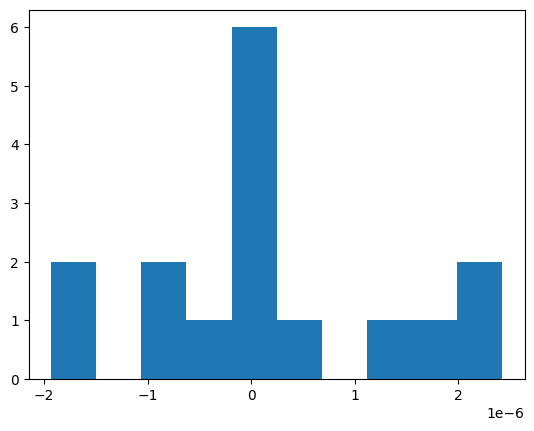

In [22]:
errors1=(predics1-T1)/T1*100
plt.hist(errors1[:,0])

In [23]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T1[:,0], y=predics1[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=T1[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=errors1[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

# Set y-axes titles
fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

# 2 sigmoids

## parameter searching

In [24]:
bp_iter=VectorBackProp(layers=[4,2,1], hidden_activation = 'sigmoid')
learning_rate = [0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], bp_iter.loss_list[-2] - bp_iter.loss_list[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1

total runs: 60
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 

In [25]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'final_loss_gradient'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss']).head()

,learning_rate,momentum_term,learning_rate_decay,final_loss,final_loss_gradient
52,0.010,0.95,0.0,0.033080,0.000003
54,0.010,0.95,0.0,0.101066,0.000003
29,0.005,0.95,0.0,0.109060,0.000046
55,0.010,0.95,0.0,0.138405,0.000008
58,0.010,0.95,0.0,0.138672,0.000009


In [26]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'final_loss_gradient', values = output_table['final_loss_gradient']),
        ])
    )
)

fig.show()

In [27]:
weights_list[47]

[[[-0.6643811665178304, -1.8889900591230133],
  [1.1824103573472033, 0.08880639472928112],
  [2.3395535772449643, 1.189827993199066],
  [3.720127129071718, 4.625876376066209]],
 [[1.7530541495636769, 2.5079049921764045]],
 [[-4.84481459945089], [3.7697358309998066]],
 [[0.5789510230286763]]]

In [28]:
man_weights_list2=[[[-1.2964859657666312, 2.3772686185611485],
  [-0.1556281657644756, -0.17766751930318456],
  [-0.24040238499962752, 3.1874378590695573],
  [2.0885535419984396, -0.5269328652357406]],
 [[-3.4832319327811017, -5.993609605680314]],
 [[-3.09207045874312], [-4.782350993626144]],
 [[0.81246344166179]]]

#  2 sigmoid  rate 0.005 mom 0.95 loss .036

## fitting best parameters

In [29]:
bp2=VectorBackProp(layers=[4,2,1], hidden_activation = 'sigmoid')

In [30]:
bp2.import_weights(man_weights_list2)
bp2.fit(X_sc1, T_sc1, epochs=10000, learning_rate = .7, momentum_term = 0.9, learning_rate_decay = .5, repeat=True)

In [31]:
fig2=go.Figure()
fig2.add_trace(go.Scatter(y=bp2.loss_list[20:], name=''))
print('Initial loss =', bp2.loss_list[0])
print('Final loss =', bp2.loss_list[-1])
fig2.show()

Initial loss = 0.036307394748911495
Final loss = 0.032795787602990296


## prediction

In [32]:
predics2=scaler_T1.inverse_transform(bp2.run(X_sc1))
# predics2

(array([1., 0., 0., 0., 1., 8., 4., 0., 0., 2.]),
 array([-9.66318466, -7.97728834, -6.29139203, -4.60549572, -2.91959941,
        -1.2337031 ,  0.45219321,  2.13808953,  3.82398584,  5.50988215,
         7.19577846]),
 <BarContainer object of 10 artists>)

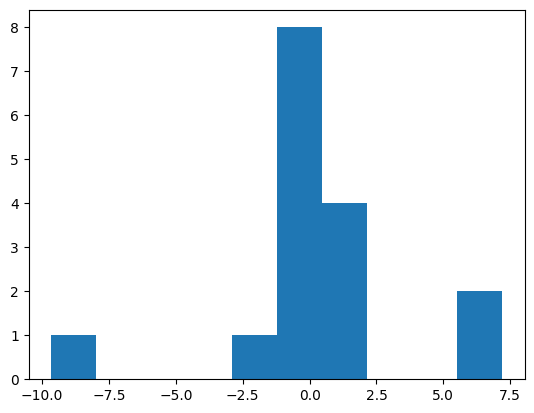

In [33]:
errors2=(predics2-T1)/T1*100
plt.hist(errors2[:,0])

In [34]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T1[:,0], y=predics2[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=T1[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=errors2[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

# Set y-axes titles
fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

# 3 sigmoids

## parameter searching

In [35]:
bp_iter=VectorBackProp(layers=[4,3,1], hidden_activation = 'sigmoid')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], bp_iter.loss_list[-2] - bp_iter.loss_list[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1

total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [36]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'final_loss_gradient'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss']).head()

,learning_rate,momentum_term,learning_rate_decay,final_loss,final_loss_gradient
82,0.010,0.95,0.0,0.000388,2.399561e-07
74,0.010,0.90,0.0,0.000688,1.117351e-06
84,0.010,0.95,0.0,0.002261,1.555754e-06
58,0.005,0.95,0.0,0.003541,4.392535e-06
51,0.005,0.95,0.0,0.003641,4.239479e-06


In [37]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'final_loss_gradient', values = output_table['final_loss_gradient']),
        ])
    )
)

fig.show()

In [38]:
weights_list[86]

[[[-6.388488030037526, -1.6797178162383648, -0.9698008044668218],
  [-1.3550777276746742, -0.31621835952398325, 1.0295181917977163],
  [0.31074481610746035, 1.4219794240078556, 2.196130297625185],
  [4.2421249342721055, 5.738568810921891, 3.7464652247266885]],
 [[3.3699485174637767, 3.154025791839019, 1.960637184944792]],
 [[1.7114228232605528], [3.2095153519419153], [-5.681550499003064]],
 [[0.4627574293404706]]]

In [39]:
man_weights_list3=[[[-2.2118161645437246, 0.2952022853729005, -1.1824878730873483],
  [4.249055770757691, 0.8304839327302308, 2.3849837843372956],
  [2.0459125929410975, 3.0217693663530616, 2.0195241666506742],
  [3.6603734746530177, -0.7084762231375126, 0.6648842734833454]],
 [[0.59387859273173, -4.478352451090628, 0.25950327378676186]],
 [[-2.937585010689068], [-4.834836121990865], [2.9499006286586895]],
 [[0.4587080458808711]]]

#  3 sigmoid  rate 0.01 mom 0.95 loss .00022

## fitting best parameters

In [40]:
bp3=VectorBackProp(layers=[4,3,1], hidden_activation = 'sigmoid')

In [41]:
bp3.import_weights(man_weights_list3)
bp3.fit(X_sc1, T_sc1, epochs=1000, learning_rate = .1, momentum_term = 0.9, learning_rate_decay = .5, repeat=True)

In [42]:
fig3=go.Figure()
fig3.add_trace(go.Scatter(y=bp3.loss_list[20:], name=''))
print('Initial loss =', bp3.loss_list[0])
print('Final loss =', bp3.loss_list[-1])
fig3.show()

Initial loss = 0.0002220564018928067
Final loss = 0.00020839189164700595


## prediction

In [43]:
predics3=scaler_T1.inverse_transform(bp3.run(X_sc1))
# predics3

(array([1., 2., 1., 1., 2., 1., 2., 2., 2., 2.]),
 array([-0.57712938, -0.47153244, -0.36593551, -0.26033857, -0.15474164,
        -0.0491447 ,  0.05645223,  0.16204917,  0.2676461 ,  0.37324304,
         0.47883997]),
 <BarContainer object of 10 artists>)

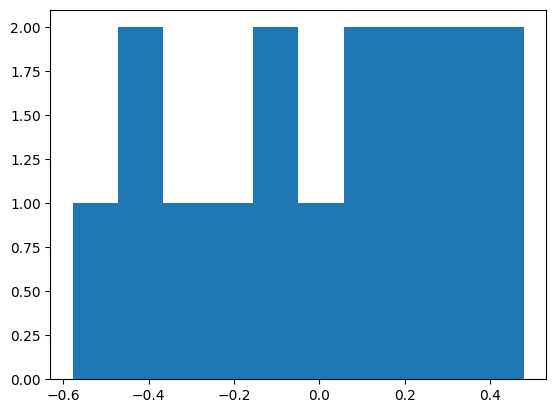

In [44]:
errors3=(predics3-T1)/T1*100
plt.hist(errors3[:,0])

In [45]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T1[:,0], y=predics3[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=T1[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=errors3[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

# Set y-axes titles
fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

# Optimization

3 sigmoids

In [46]:
def yield_predict3(x):
  return -scaler_T1.inverse_transform(bp3.run(scaler_X1.transform([x])))[0,0]

In [47]:
# yield_predict3([60,1.2,120,3.8])

In [48]:
bnds=((60,120),(1.2,2.4),(100,120),(3.8,11.7))
sol3=optimize.minimize(yield_predict3, [60,1.2,120,3.8], bounds=bnds)

In [49]:
print (sol3.fun, sol3.x)

-51.755915852477486 [ 60.           1.57340384 113.98087862   3.8       ]


4 sigmoids

In [50]:
def yield_predict1(x):
  return -scaler_T1.inverse_transform(bp1.run(scaler_X1.transform([x])))[0,0]

In [51]:
# yield_predict1([60,1.2,120,3.8])

In [52]:
bnds=((60,120),(1.2,2.4),(100,120),(3.8,11.7))
sol1=optimize.minimize(yield_predict1, [60,1.2,120,3.8], bounds=bnds)

In [53]:
print (sol1.fun, sol1.x)

-55.18032929365478 [ 92.46779537   1.84739935 106.18911586   3.8       ]


# Vizualization

### 4 sigmoids

In [54]:
Xmesh, Ymesh, Zmesh = np.mgrid[60:240:21j, 1.2:2.4:25j, 100:120:25j] #Time, HBr, T
values1=Xmesh.copy() # initial
for i in range(len(Xmesh)):
    for j in range(len(Xmesh[0])):
        for k in range(len(Xmesh[0,0])):
            values1[i,j,k]=scaler_T1.inverse_transform(bp1.run(scaler_X1.transform([[Xmesh[i,j,k],Ymesh[i,j,k],Zmesh[i,j,k],3.8]])))[0,0]

In [55]:
fig = go.Figure()

values=values1
fig.add_trace(go.Isosurface(
    x=Xmesh.flatten(), # Time
    y=Ymesh.flatten(), # HBr
    z=Zmesh.flatten(), # T
    value=values.flatten(),
    isomin=20,
    isomax=60,
    surface_count=20,
    opacity=0.15,
    surface_fill=1,
    # colorscale=mycolorscale,
    # showscale=False,
    caps=dict(x_show=False, y_show=False, z_show=False),
    showlegend=True,
    ))
fig.add_trace(go.Scatter3d(x=[sol1.x[0]], y=[sol1.x[1]], z=[sol1.x[2]], showlegend=False))
fig.update_layout(
        scene = dict(
                xaxis_title='Time, min',
                yaxis_title='HBr, gr',
                zaxis_title='T, C',
                ),
            # scene_camera_eye=dict(x=0, y=-2, z=0),
            width=1200,height=800,
            margin=dict(r=20, b=20, l=10, t=0),
            legend_y=.3,
            showlegend=True,
#             paper_bgcolor="LightGrey",
        )
fig.show()

### 3 sigmoids

In [56]:
# Xmesh, Ymesh, Zmesh = np.mgrid[60:240:11j, 1.2:2.4:13j, 100:120:11j] #Time, HBr, T
values3=Xmesh.copy() # initial
for i in range(len(Xmesh)):
    for j in range(len(Xmesh[0])):
        for k in range(len(Xmesh[0,0])):
            values3[i,j,k]=scaler_T1.inverse_transform(bp3.run(scaler_X1.transform([[Xmesh[i,j,k],Ymesh[i,j,k],Zmesh[i,j,k],3.8]])))[0,0]

In [61]:
fig = go.Figure()

values=values3
fig.add_trace(go.Isosurface(
    x=Xmesh.flatten(), # Time
    y=Ymesh.flatten(), # HBr
    z=Zmesh.flatten(), # T
    value=values.flatten(),
    isomin=20,
    isomax=60,
    surface_count=20,
    opacity=0.15,
    surface_fill=1,
    # colorscale=mycolorscale,
    # showscale=False,
    caps=dict(x_show=False, y_show=False, z_show=False),
    name='Yield',
    showlegend=True,
    ))
fig.add_trace(go.Scatter3d(x=[sol3.x[0]], y=[sol3.x[1]], z=[sol3.x[2]], showlegend=False))
fig.update_layout(
        scene = dict(
                xaxis_title='Time, min',
                yaxis_title='HBr, gr',
                zaxis_title='T, C',
                ),
            # scene_camera_eye=dict(x=0, y=-2, z=0),
            width=1200,height=800,
            margin=dict(r=20, b=20, l=10, t=0),
            showlegend=True,
            paper_bgcolor="LightGrey",
        )
fig.show()

# old data comparison

In [58]:
data2=CopyPasteToArray('''
Time	HBr	T	Wood Load	Y
240	1.2	100	11.7	34.4
240	2.4	100	3.8	37.8
240	1.2	110	11.7	32.4
120	2.4	110	3.8	34.3
120	1.2	120	3.8	38
120	1.2	120	11.7	38.3
90	1.2	120	3.8	38.1
45	1.2	120	3.8	42.9
60	1	120	3.8	42.3
60	1.2	120	11.7	37.3
''')
df2=pd.DataFrame(data2[1:], columns=data[0])

In [59]:
df2_1=df2.copy()
df2_1['predics']=scaler_T1.inverse_transform(bp1.run(scaler_X1.transform(df2[['Time',	'HBr',	'T',	'Wood Load']])))
df2_1['error']=(df2_1['predics']-df2['Y'])*100/df2['Y']
df2_1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



,Time,HBr,T,Wood Load,Y,predics,error
0,240,1.2,100,11.7,34.4,39.499999,14.825579
1,240,2.4,100,3.8,37.8,40.396714,6.869614
2,240,1.2,110,11.7,32.4,38.781813,19.696953
3,120,2.4,110,3.8,34.3,34.997953,2.034849
4,120,1.2,120,3.8,38.0,44.100680,16.054421
5,120,1.2,120,11.7,38.3,25.011274,-34.696411
6,90,1.2,120,3.8,38.1,46.080643,20.946570
7,45,1.2,120,3.8,42.9,46.631402,8.697908
8,60,1.0,120,3.8,42.3,43.672366,3.244364
9,60,1.2,120,11.7,37.3,21.182668,-43.210004


In [60]:
df2_3=df2.copy()
df2_3['predics']=scaler_T1.inverse_transform(bp3.run(scaler_X1.transform(df2[['Time',	'HBr',	'T',	'Wood Load']])))
df2_3['error']=(df2_3['predics']-df2['Y'])*100/df2['Y']
df2_3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



,Time,HBr,T,Wood Load,Y,predics,error
0,240,1.2,100,11.7,34.4,39.689142,15.375412
1,240,2.4,100,3.8,37.8,43.857365,16.024776
2,240,1.2,110,11.7,32.4,39.027273,20.454548
3,120,2.4,110,3.8,34.3,38.064098,10.974048
4,120,1.2,120,3.8,38.0,39.686805,4.438959
5,120,1.2,120,11.7,38.3,32.112044,-16.156544
6,90,1.2,120,3.8,38.1,43.246643,13.508250
7,45,1.2,120,3.8,42.9,48.134953,12.202688
8,60,1.0,120,3.8,42.3,42.956140,1.551159
9,60,1.2,120,11.7,37.3,35.422093,-5.034604
